# figures for grant

1. scatter showing seperation of 3 brain regions: ca1, mec, and pfc
2. raw traces of 3 brain regions during theta and ripples
3. CA1 place cell examples from multiple mazes

In [1]:
%reload_ext autoreload
%autoreload 2
from ripple_heterogeneity.utils import loading,functions,add_new_deep_sup
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os
import matplotlib

functions.set_plotting_defaults()
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
fig_save_path = r'Z:\home\ryanh\projects\ripple_heterogeneity\figures\panels'

# Figure 1

## load several sessions

In [5]:
df = pd.DataFrame()
df["basepath"] = ['Z:\Data\HMC1\day8',
    'Z:\Data\HMC1\day9',
    'Z:\Data\HMC1\day10',
    'Z:\Data\HMC1\day12',
    'Z:\Data\HMC1\day13',
    'Z:\Data\HMC1\day14'
    ]
cm = loading.load_all_cell_metrics(df.basepath)

## simplify regions

In [28]:
cm.loc[cm.brainRegion.str.contains("CA1"), 'brainRegion'] = 'CA1'
cm.loc[cm.brainRegion.str.contains("PFC"), 'brainRegion'] = 'PFC'
cm.loc[cm.brainRegion.str.contains("MEC"), 'brainRegion'] = 'MEC'
cm.brainRegion.unique()

array(['PFC', 'Unknown', 'CA1', 'V1', 'MEC'], dtype=object)

## only keep ca1, mec, pfc

In [29]:
cm = cm.query('brainRegion.str.contains("CA1|PFC|MEC")')
cm.brainRegion.unique()


array(['PFC', 'CA1', 'MEC'], dtype=object)

## make classifier for brain regions using many variables in order to find important variables for tsne

In [34]:
variables = [
        "ab_ratio",
        "acg_asymptote",
        "acg_c",
        "acg_d",
        "acg_fit_rsquare",
        "acg_h",
        "acg_refrac",
        "acg_tau_burst",
        "acg_tau_decay",
        "acg_tau_rise",
        "burstIndex_Doublets",
        "burstIndex_MA",
        "burstIndex_Mizuseki2012",
        "burstIndex_Royer2012",
        "cv2",
        "firingRate",
        "firingRateCV",
        "firingRateGiniCoeff",
        "firingRateISI",
        "firingRateInstability",
        "peakVoltage",
        "peakVoltage_expFit",
        "peakVoltage_expFitLengthConstant",
        "phy_amp",
        "population_modIndex",
        "ripple_FRall",
        "rankorder",
        "ripple_FRparticip",
        "ripple_GainAll",
        "ripple_GainParticip",
        "ripple_nSpkAll",
        "ripple_particip",
        "ripples_modulationIndex",
        "ripples_modulationPeakResponseTime",
        "spikeCount",
        "thetaModulationIndex",
    ]
X = cm[variables].values
y = cm.brainRegion.values

# remove nan and inf values
bad_idx = np.isnan(X).any(axis=1) | np.isinf(X).any(axis=1)
y = y[~bad_idx]
X = X[~bad_idx]


# standardize X 
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)
X

array([[ 0.03900539,  1.76155384, -0.98495293, ...,  0.00415371,
         1.64025929,  0.33903639],
       [ 0.45673805,  0.14947176, -0.71014532, ...,  0.46744236,
         0.01119072,  0.84448136],
       [-0.4193753 , -0.26752968, -0.34177722, ...,  0.39505351,
        -0.5034807 , -2.26225521],
       ...,
       [ 2.33099365,  1.85575129,  0.19464469, ..., -0.16957954,
         2.83129151,  0.86729991],
       [ 1.90527622,  0.19198266,  0.12296574, ..., -0.41570164,
         0.75441872,  0.34702975],
       [ 2.17841665,  1.66654465, -0.51500898, ...,  0.22132026,
         2.4358947 ,  0.39267905]])

## run classifier on all variables

In [ ]:
from sklearn.ensemble import ExtraTreesClassifier
clf = ExtraTreesClassifier(n_estimators=100, random_state=0)
clf.fit(X, y)


## inspect importance of variables

[Text(0.5, 0, 'Feature Importance'), Text(0, 0.5, 'Feature')]

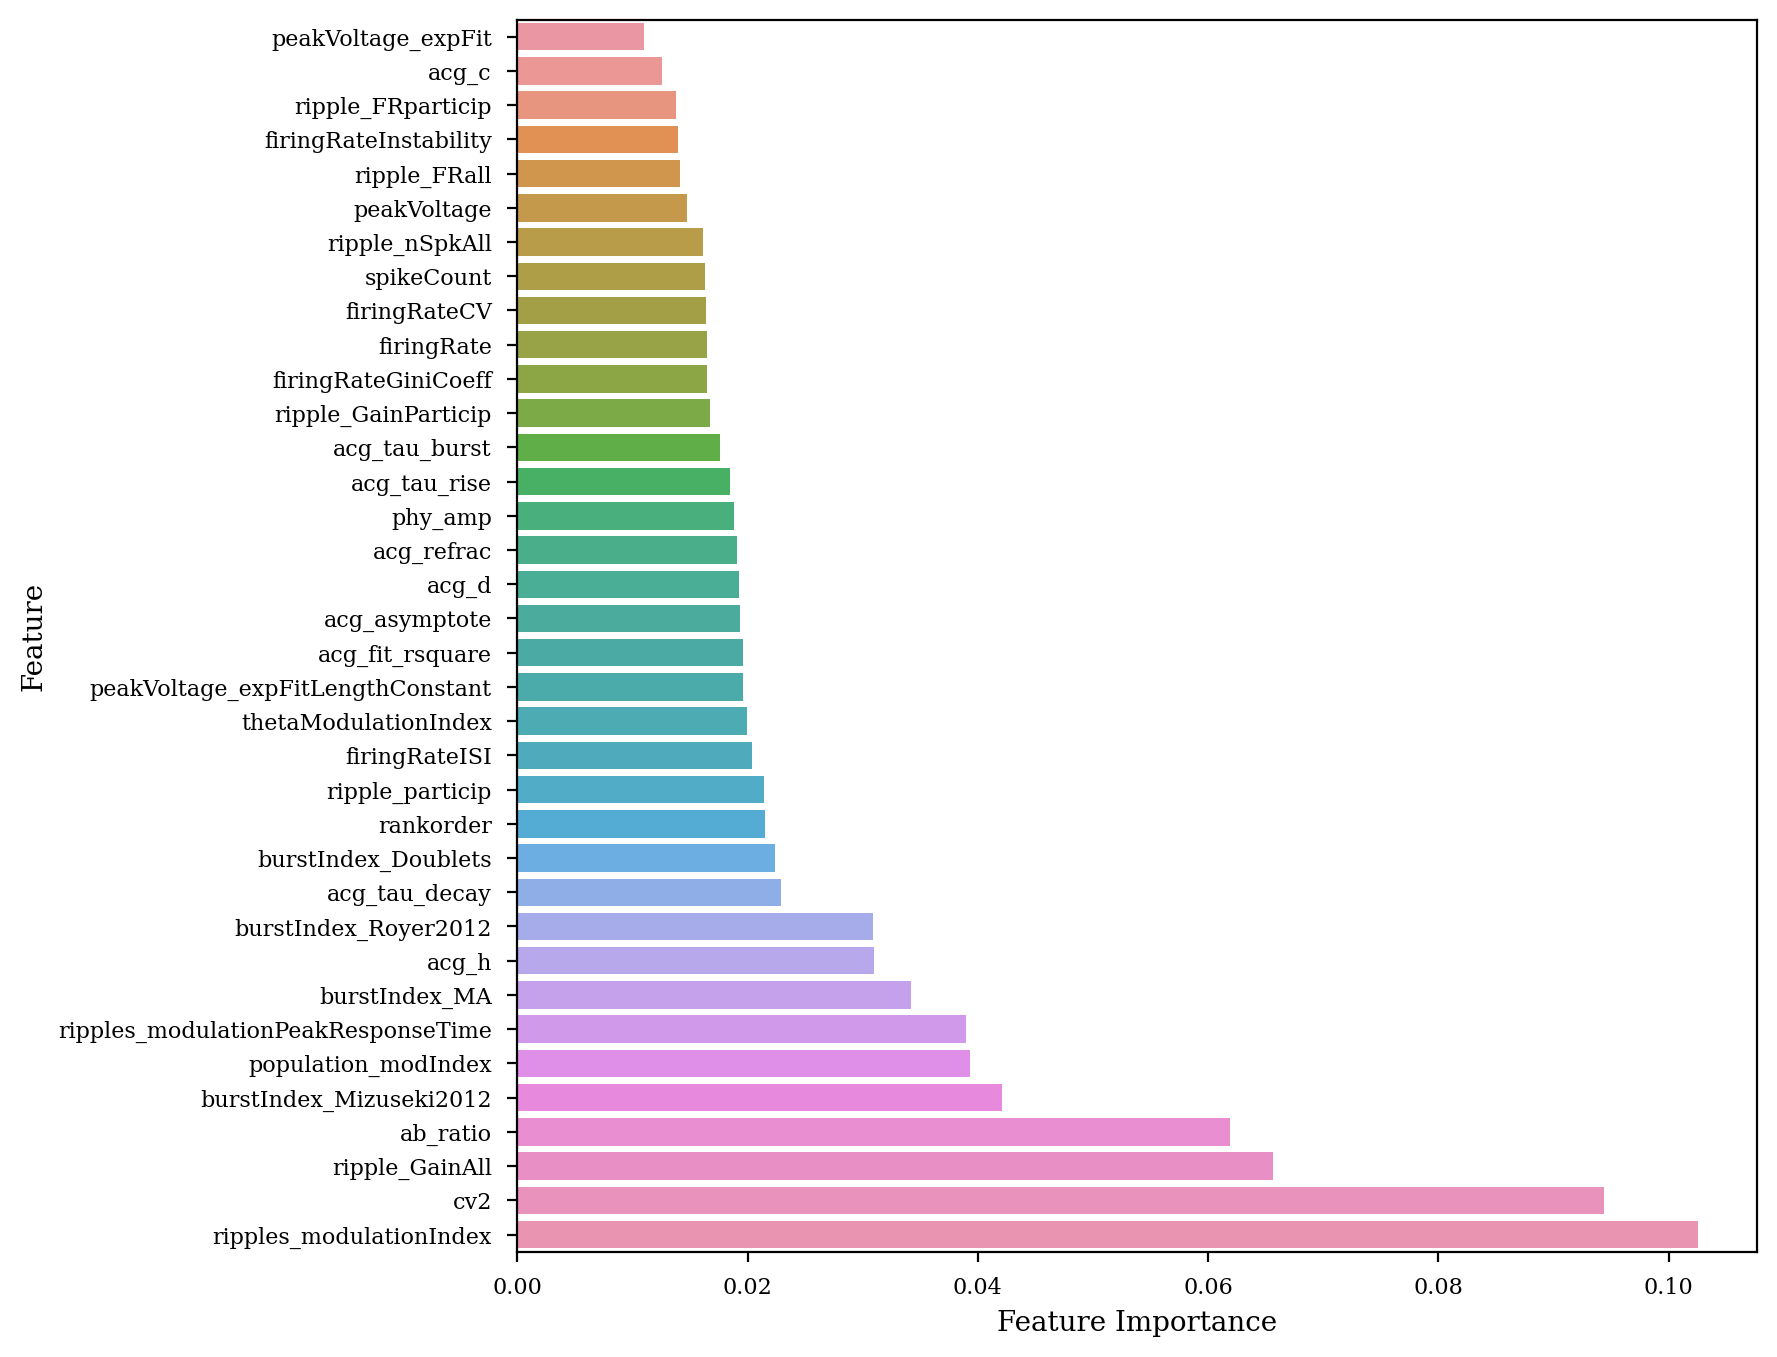

In [37]:
# make plot of feature_importances_
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot(x=np.sort(clf.feature_importances_), y=np.array(variables)[np.argsort(clf.feature_importances_)], ax=ax)
ax.set(xlabel='Feature Importance', ylabel='Feature')


<AxesSubplot: xlabel='ripples_modulationIndex', ylabel='cv2'>

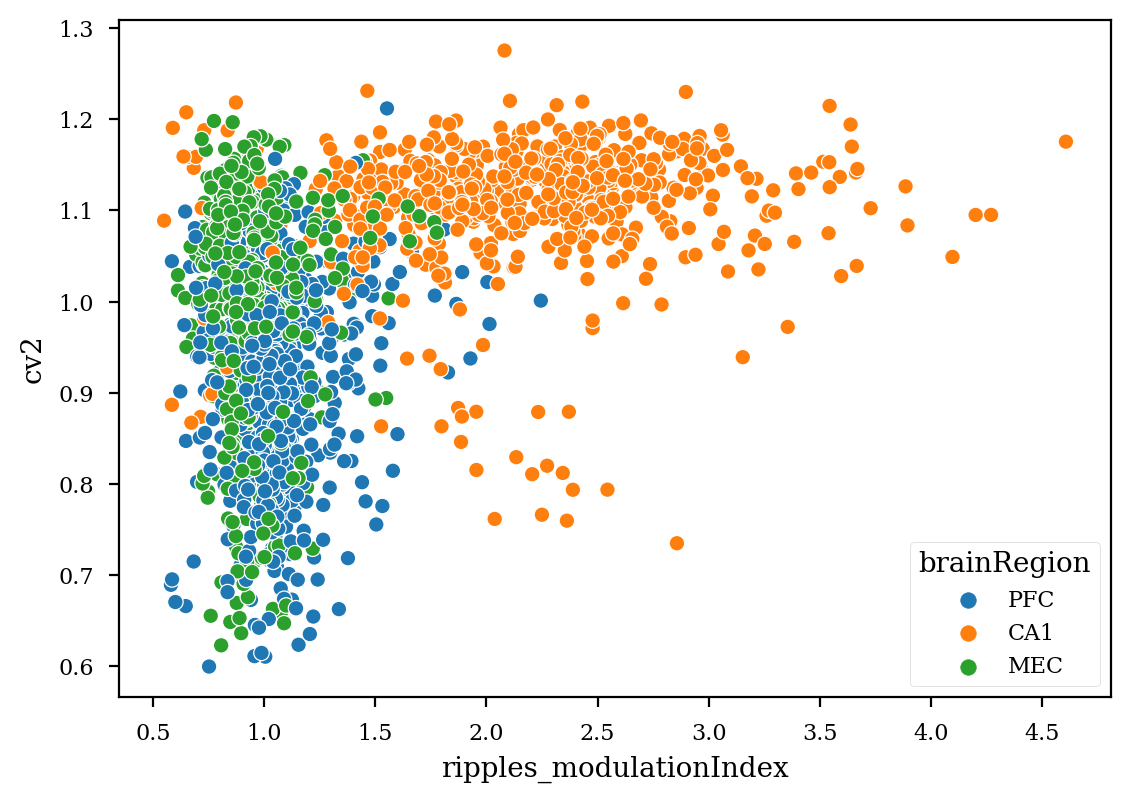

In [38]:
sns.scatterplot(x='ripples_modulationIndex', y='cv2', hue='brainRegion', data=cm)

## run tsne on top 5 important variables

In [95]:
np.array(variables)[np.argsort(-clf.feature_importances_)][:5]

array(['ripples_modulationIndex', 'cv2', 'ripple_GainAll', 'ab_ratio',
       'burstIndex_Mizuseki2012'], dtype='<U34')

c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\sklearn\manifold\_t_sne.py:800: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
c:\Users\Cornell\anaconda3\envs\ripple_heterogeneity\lib\site-packages\sklearn\manifold\_t_sne.py:810: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
C:\Users\Cornell\AppData\Local\Temp\ipykernel_33376\720021573.py:19: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored


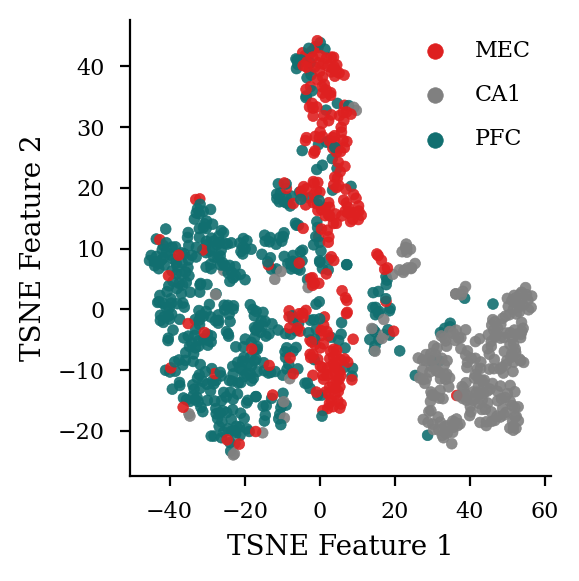

In [90]:
from sklearn.manifold import Isomap, TSNE
embedding = TSNE(n_components=2,random_state=42)
X_transformed = embedding.fit_transform(X[:,np.argsort(-clf.feature_importances_)][:,:5])

# turn y into color sequence
# from matplotlib.colors import ListedColormap
group_colors = {
    "MEC": "#de2020",
    "CA1": "grey",
    "PFC": "#116f70",
}
# cmap = ListedColormap(sns.color_palette(group_colors.values()).as_hex())
y_color = [group_colors[region] for region in y]

fig = plt.figure(
    figsize=(3,3), edgecolor=None
)

plt.scatter(X_transformed[:,0], X_transformed[:,1], c=y_color, alpha=.9,s=15)
plt.xlabel('TSNE Feature 1')
plt.ylabel('TSNE Feature 2')
sns.despine()
# label colors on plot
for region, color in group_colors.items():
    plt.scatter([], [], c=color, label=region)
plt.legend(scatterpoints=1, frameon=False, labelspacing=1, title='')
plt.tight_layout()

plt.savefig(
    os.path.join(fig_save_path, "tsne_ca1_mec_pfc_grant.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "tsne_ca1_mec_pfc_grant.pdf"),
    dpi=300,
    bbox_inches="tight",
)

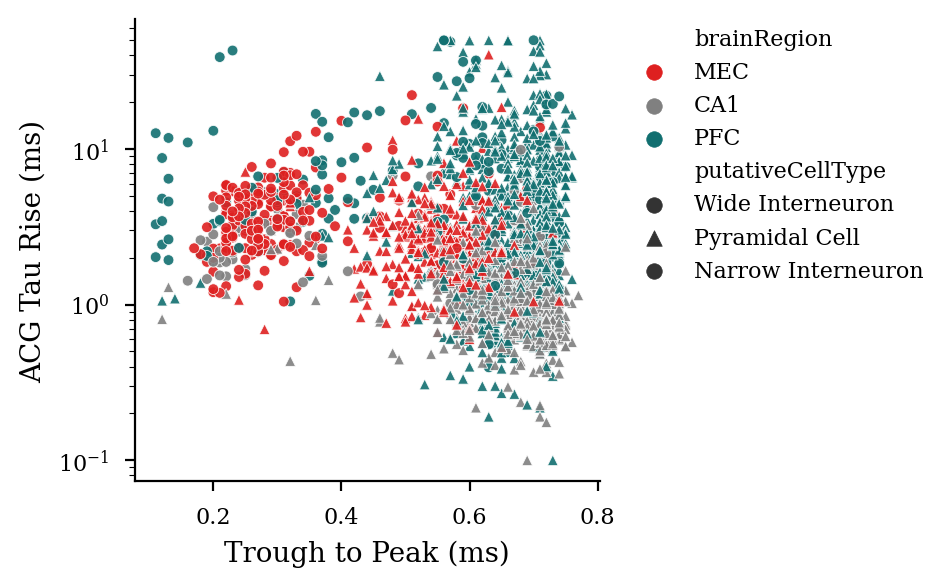

In [117]:
fig = plt.figure(figsize=(3, 3), edgecolor=None)
sns.set_palette(sns.color_palette(group_colors.values()))
markers = {"Wide Interneuron": "o", "Narrow Interneuron": "o", "Pyramidal Cell": "^"}

sns.scatterplot(
    x="troughToPeak",
    y="acg_tau_rise",
    hue="brainRegion",
    hue_order=group_colors.keys(),
    data=cm,
    style="putativeCellType",
    markers=markers,
    alpha=0.9,
    s=15,
)
plt.ylabel("ACG Tau Rise (ms)")
plt.xlabel("Trough to Peak (ms)")
plt.yscale("log")
# move legend outside of plot
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0, frameon=False,title='')
sns.despine()

plt.savefig(
    os.path.join(fig_save_path, "troughToPeak_acg_tau_rise_grant.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "troughToPeak_acg_tau_rise_grant.pdf"),
    dpi=300,
    bbox_inches="tight",
)


In [119]:
cm[["brainRegion","putativeCellType"]].value_counts().reset_index().rename(columns={0:'count'})

brainRegion    putativeCellType  count
0         PFC      Pyramidal Cell    800
1         CA1      Pyramidal Cell    534
2         MEC      Pyramidal Cell    299
3         MEC  Narrow Interneuron    225
4         PFC  Narrow Interneuron    121
5         PFC    Wide Interneuron     73
6         CA1  Narrow Interneuron     44
7         MEC    Wide Interneuron     23
8         CA1    Wide Interneuron     17

# Figure 2

In [237]:

# lfp = loading.LoadLfp(r"Z:\Data\HMC1\day9",ext="dat",epoch=np.array([27424.5,27424.5+1]))
basepath = r"Z:\Data\HMC1\day8"

lfp = loading.LoadLfp(basepath,ext="dat",epoch=np.array([11927.2056,11927.2056 + .2]))


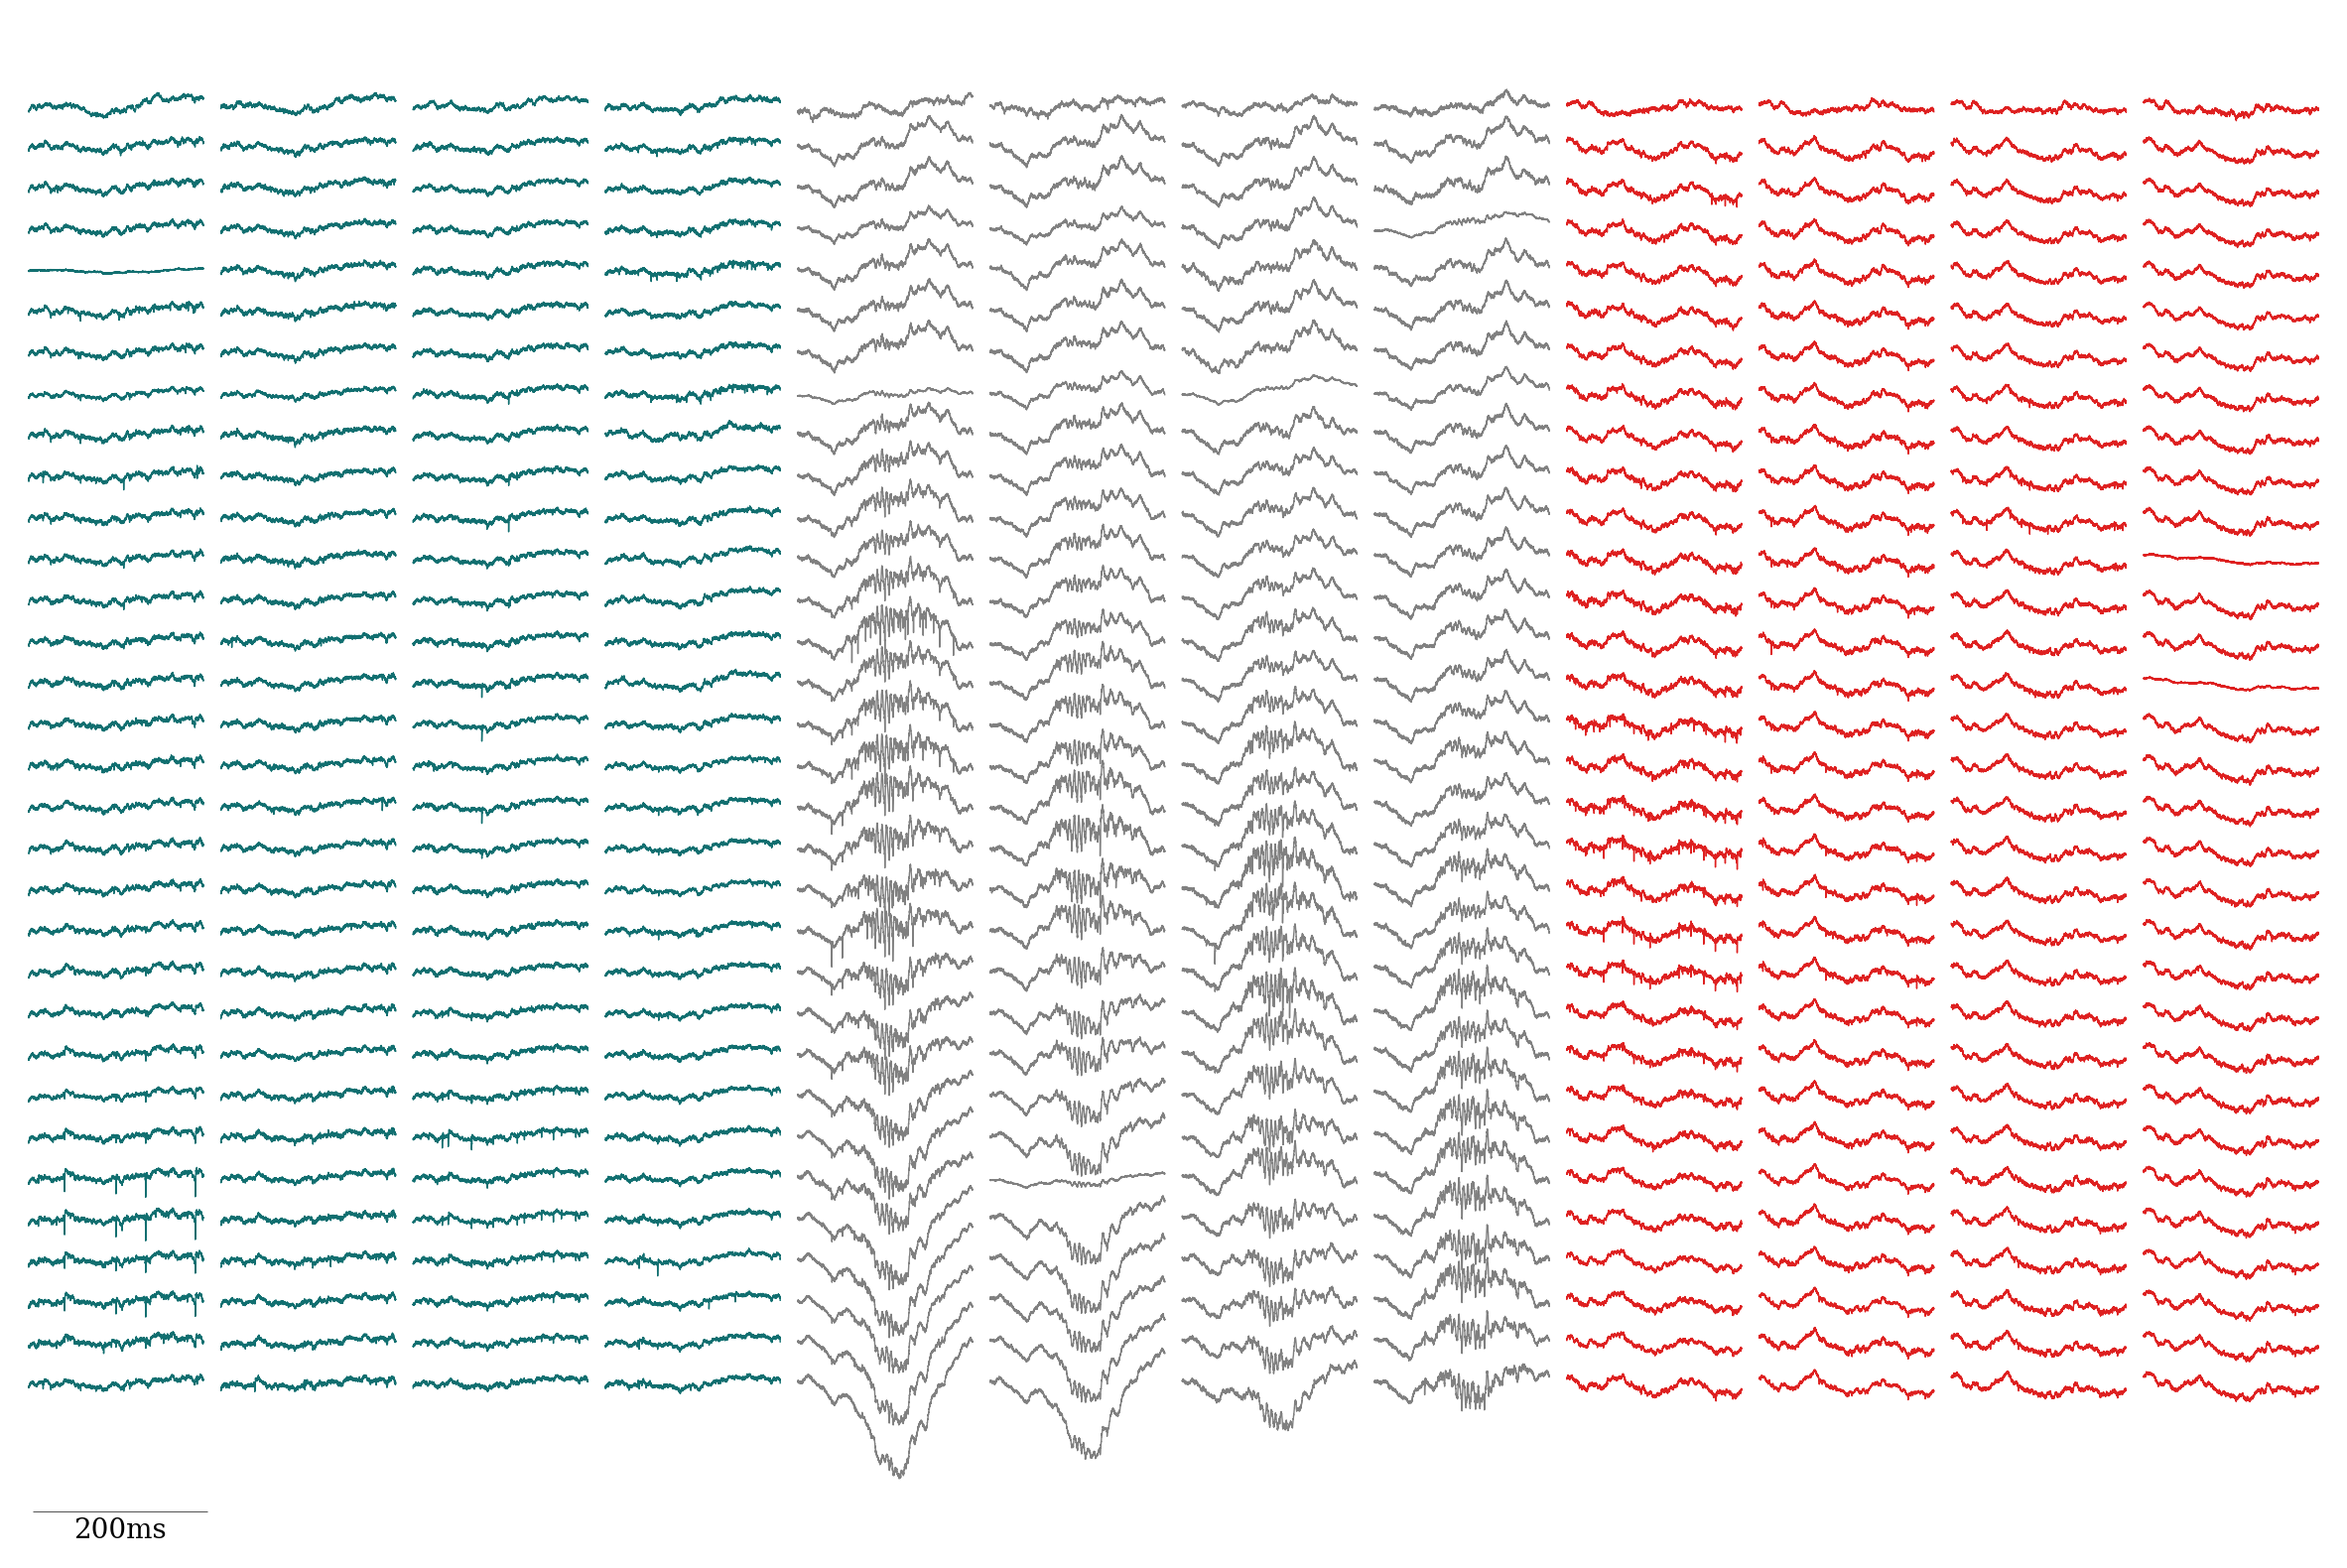

In [248]:
from ripple_heterogeneity.utils import scalebars

shanks = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15]
group_colors = {
    "MEC": "#de2020",
    "CA1": "grey",
    "PFC": "#116f70",
}
fig, ax = plt.subplots(1, 12, figsize=(15, 10), sharex=True, sharey=True)
# remove space between subplots
fig.subplots_adjust(wspace=0, hspace=0)
for shank_i, shank_num in enumerate(shanks):
    if shank_num < 4:
        current_color = group_colors["PFC"]
    elif (shank_num > 7) & (shank_num < 12):
        current_color = group_colors["CA1"]
    else:
        current_color = group_colors["MEC"]

    ax[shank_i].plot(
        lfp.lfp.abscissa_vals,
        lfp.lfp.data[lfp.shank_to_channel[shank_num], :].T - np.linspace(0, 150_000, len(lfp.shank_to_channel[shank_num])),
        color=current_color,
        linewidth=0.5,
    )
    ax[shank_i].set_axis_off()

sb = scalebars.add_scalebar(ax[0],sizex=.2, labelx="200ms",labely="voltage",matchx=False, matchy=False, hidex=True,hidey=False)

plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_ripple_trace_grant_v3.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_ripple_trace_grant_v3.pdf"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()


In [249]:
lfp = loading.LoadLfp(basepath,ext="dat",epoch=np.array([10119.0445,10119.0445 + 1]))


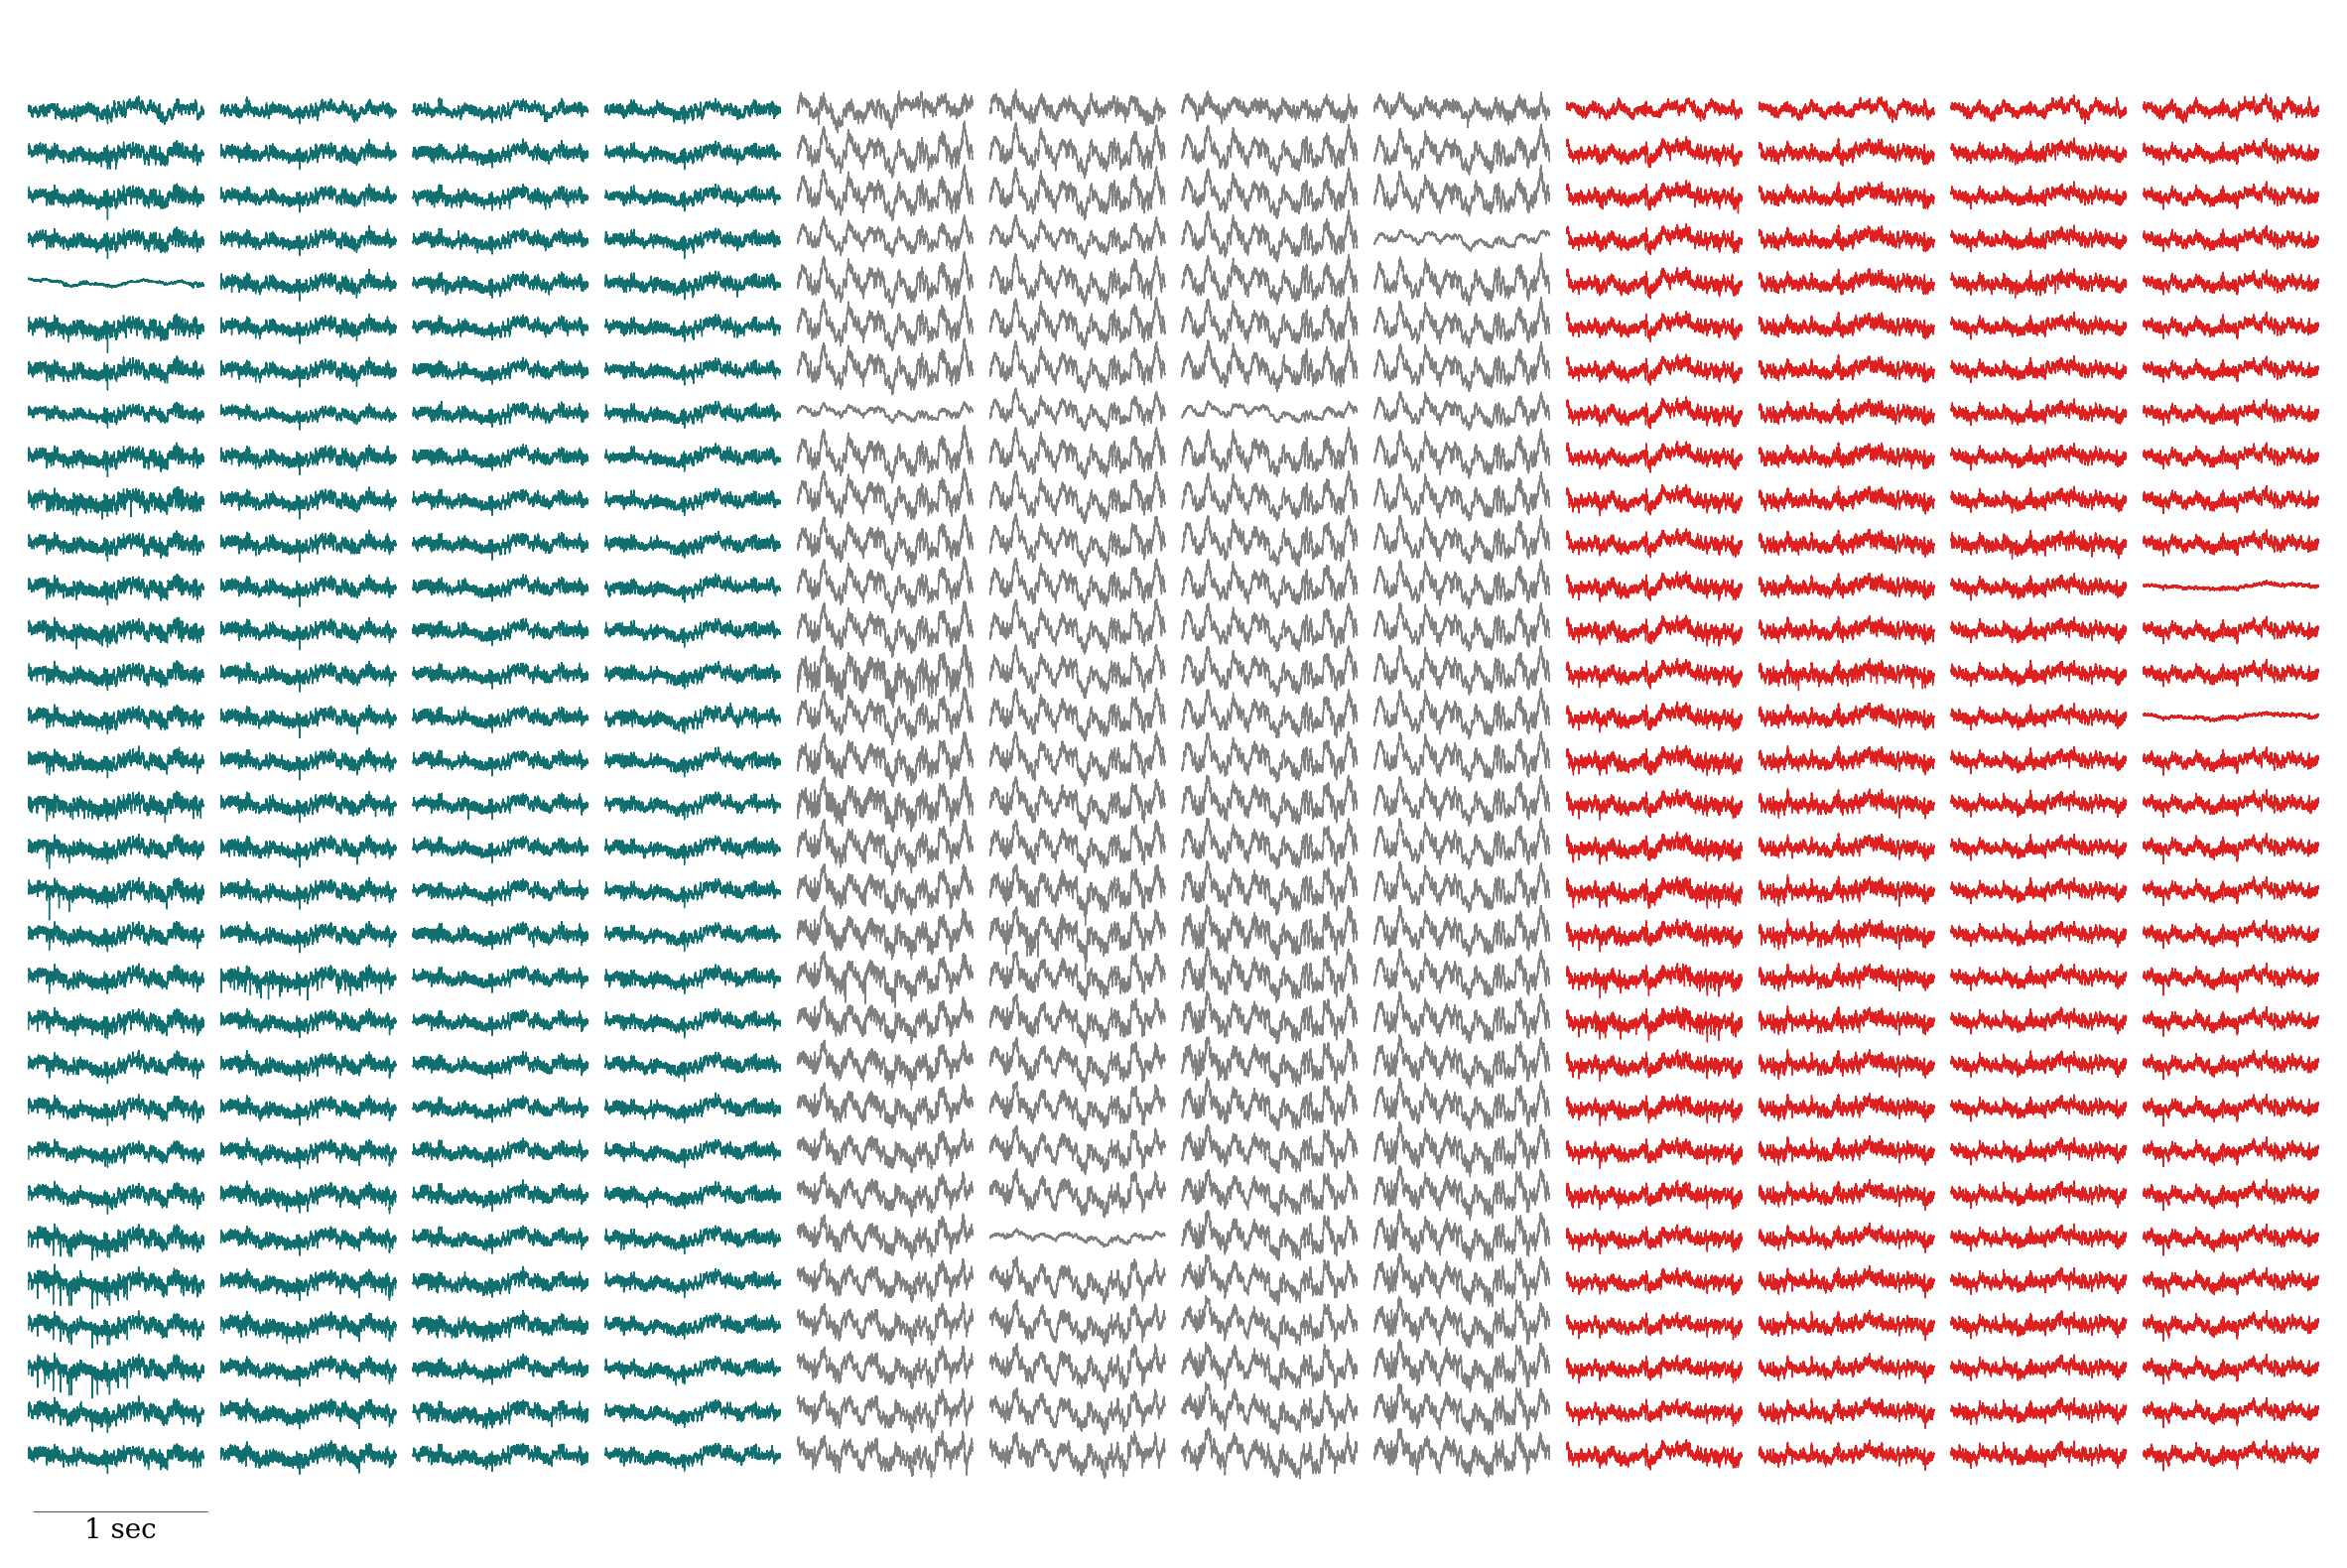

In [251]:
shanks = [0, 1, 2, 3, 8, 9, 10, 11, 12, 13, 14, 15]
group_colors = {
    "MEC": "#de2020",
    "CA1": "grey",
    "PFC": "#116f70",
}
fig, ax = plt.subplots(1, 12, figsize=(15, 10), sharex=True, sharey=True)
# remove space between subplots
fig.subplots_adjust(wspace=0, hspace=0)
for shank_i, shank_num in enumerate(shanks):
    if shank_num < 4:
        current_color = group_colors["PFC"]
    elif (shank_num > 7) & (shank_num < 12):
        current_color = group_colors["CA1"]
    else:
        current_color = group_colors["MEC"]

    ax[shank_i].plot(
        lfp.lfp.abscissa_vals,
        lfp.lfp.data[lfp.shank_to_channel[shank_num], :].T - np.linspace(0, 150_000, len(lfp.shank_to_channel[shank_num])),
        color=current_color,
        linewidth=0.5,
    )
    ax[shank_i].set_axis_off()

sb = scalebars.add_scalebar(ax[0],sizex=1, labelx="1 sec",labely="voltage",matchx=False, matchy=False, hidex=True,hidey=False)

plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_theta_trace_grant_v3.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_theta_trace_grant_v3.pdf"),
    dpi=300,
    bbox_inches="tight",
)

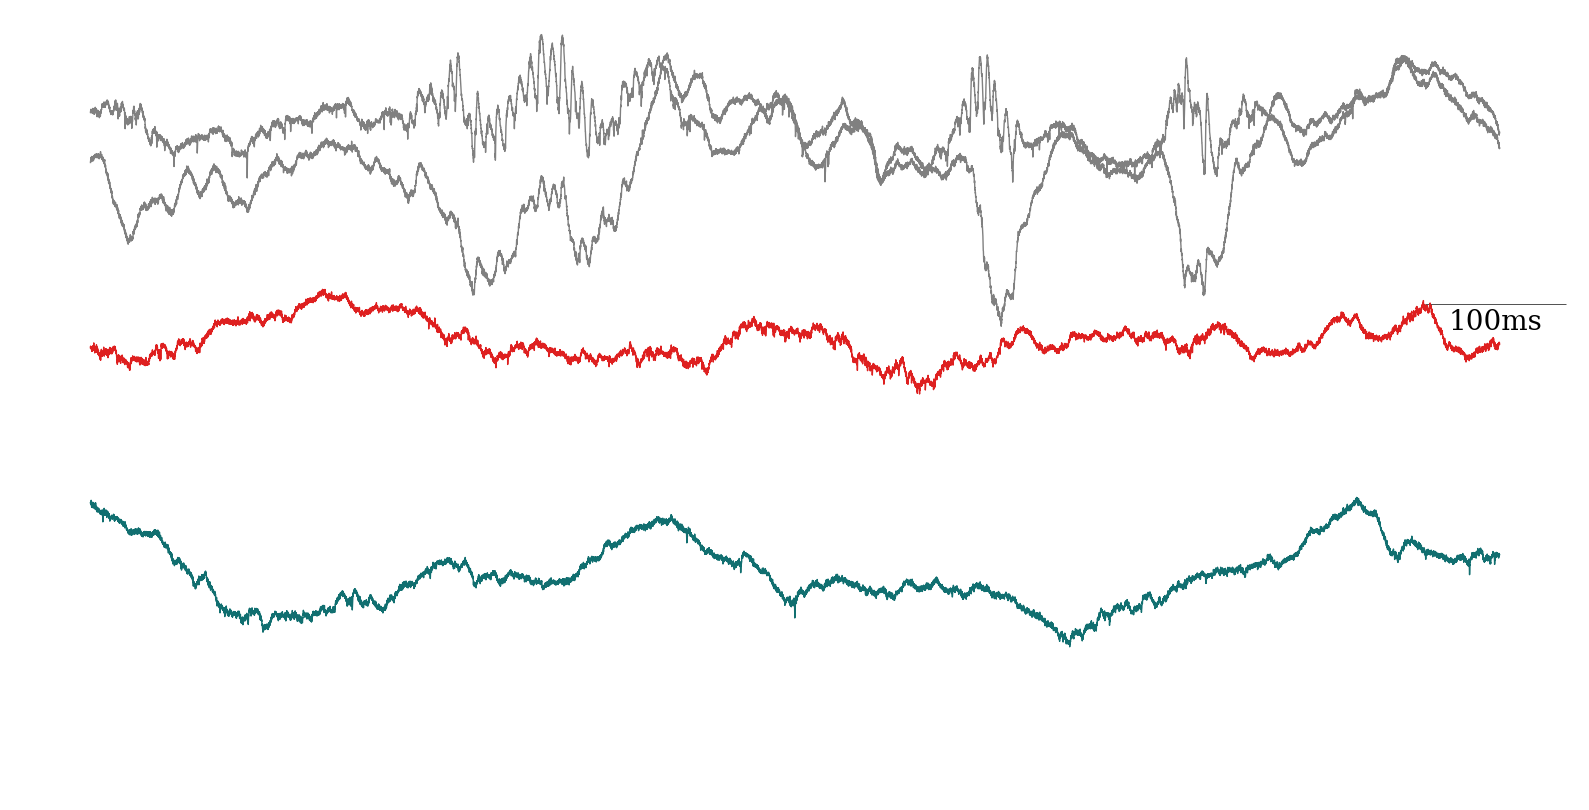

In [217]:
from ripple_heterogeneity.utils import scalebars

group_colors = {
    "MEC": "#de2020",
    "CA1": "grey",
    "PFC": "#116f70",
}
fig,ax = plt.subplots(3,1,figsize=(10,5),sharex=True,sharey=True)
# decrease space between subplots
plt.subplots_adjust(hspace=-.3)
ax[0].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[260],:].T, color=group_colors['CA1'],linewidth=.5)
ax[0].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[283],:].T - 2500, color=group_colors['CA1'],linewidth=.5)
ax[1].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[400],:].T, color=group_colors['MEC'],linewidth=.5)
ax[2].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[10],:].T, color=group_colors['PFC'],linewidth=.5)

sb = scalebars.add_scalebar(ax[0],sizex=.1, labelx="100ms",labely="voltage",matchx=False, matchy=False, hidex=True,hidey=False)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_ripple_trace_grant.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_ripple_trace_grant.pdf"),
    dpi=300,
    bbox_inches="tight",
)

plt.show()

In [218]:
lfp = loading.LoadLfp(r"Z:\Data\HMC1\day9",ext="dat",epoch=np.array([12869.9,12869.9+1]))

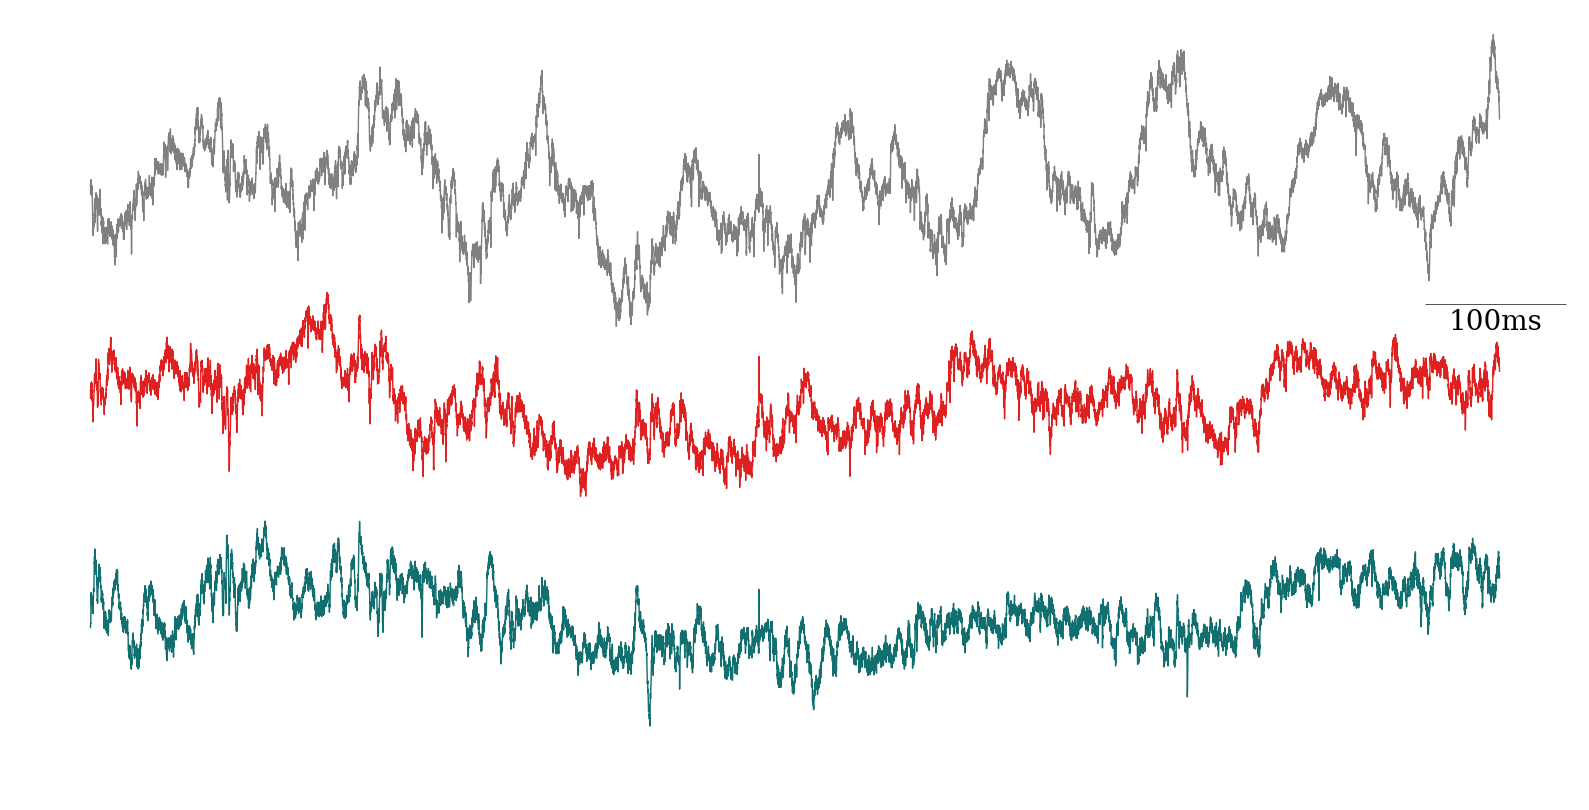

In [219]:

fig,ax = plt.subplots(3,1,figsize=(10,5),sharex=True,sharey=True)
# decrease space between subplots
plt.subplots_adjust(hspace=-.3)
ax[0].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[260],:].T, color=group_colors['CA1'],linewidth=.5)
# ax[0].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[283],:].T - 2500, color=group_colors['CA1'],linewidth=.5)
ax[1].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[400],:].T, color=group_colors['MEC'],linewidth=.5)
ax[2].plot(lfp.lfp.abscissa_vals, lfp.lfp.data[[10],:].T, color=group_colors['PFC'],linewidth=.5)

sb = scalebars.add_scalebar(ax[0],sizex=.1, labelx="100ms",labely="voltage",matchx=False, matchy=False, hidex=True,hidey=False)

ax[0].set_axis_off()
ax[1].set_axis_off()
ax[2].set_axis_off()

plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_theta_trace_grant.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "ca1_mec_pfc_theta_trace_grant.pdf"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()

# Figure 3

In [265]:
import nelpy as nel
basepath = r"Z:\Data\HMC2\day4"
# load position
position_df = loading.load_animal_behavior(basepath)
# restrict to non-nan times
position_df_no_nan = position_df.query("not x.isnull() & not y.isnull()")
# put position into a nelpy position array for ease of use
pos = nel.AnalogSignalArray(
    data=position_df_no_nan["linearized"].values.T,
    timestamps=position_df_no_nan.timestamps.values,
)
# load in spike data from hpc pyramidal cells
st,cm = loading.load_spikes(basepath,putativeCellType="Pyr",brainRegion="CA1")

epoch_df = loading.load_epoch(basepath)
beh_epochs = nel.EpochArray(np.array([epoch_df.startTime,epoch_df.stopTime]).T)

# you can change this based on which session you want to look at
behavior_idx = 1

# print out data frame
epoch_df

name   startTime     stopTime environment  \
0    presleep_221013_110706      0.0000   5576.06395       sleep   
1      linear_221013_124548   5576.0640   8048.01915      linear   
2   postsleep_221013_132715   8048.0192  11447.01915       sleep   
3  postSleep2_221013_143024  11447.0192  17185.37435       sleep   

            basepath  
0  Z:\Data\HMC2\day4  
1  Z:\Data\HMC2\day4  
2  Z:\Data\HMC2\day4  
3  Z:\Data\HMC2\day4

In [266]:
# get outbound and inbound epochs
(outbound_epochs, inbound_epochs) = functions.get_linear_track_lap_epochs(
    pos[beh_epochs[behavior_idx]].abscissa_vals, pos[beh_epochs[behavior_idx]].data[0], newLapThreshold=20
)
outbound_epochs, inbound_epochs

d:\github\ripple_heterogeneity\ripple_heterogeneity\utils\functions.py:993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


(<EpochArray at 0x2182df8cf40: 22 epochs> of length 22:48:475 minutes,
 <EpochArray at 0x2182df8c970: 21 epochs> of length 16:35:825 minutes)

In [268]:
from ripple_heterogeneity.place_cells import maps

spatial_maps = maps.SpatialMap(
    pos[beh_epochs[behavior_idx]],
    st[beh_epochs[behavior_idx]],
    dim=1,
    dir_epoch=outbound_epochs,
    s_binsize=3,
    tuning_curve_sigma=3,
    place_field_min_size=15,
    place_field_max_size=1000,
    place_field_sigma=3,
)
# spatial_maps.find_fields()

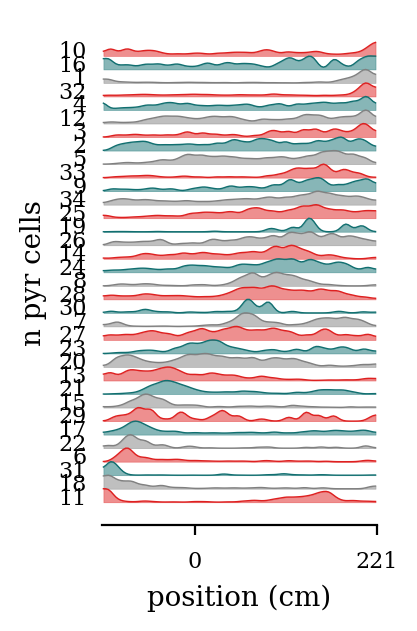

In [300]:
import nelpy.plotting as npl
tc = spatial_maps.tc

w, h = functions.set_size("thesis", fraction=0.3, subplots=(3, 1))

with npl.FigureManager(show=True, figsize=(w, h)) as (fig, ax):
    npl.utils.skip_if_no_output(fig)
    ax1 = npl.plot_tuning_curves1D(
        tc.smooth(sigma=5).reorder_units(), normalize=True, pad=1, fill=True, alpha=0.5
    )

    leg_lines = ax1.get_lines()
    plt.setp(leg_lines, linewidth=0.5)
    ax.set_xlabel("position (cm)")
    ax.set_ylabel("n pyr cells")
    ax.set_xticks([0, tc.bins.max()])

In [ ]:
spk_pos = []
for ep_i, ep in enumerate(outbound_epochs):
    spk_pos.append(
        np.interp(
            st[ep[spatial_maps.run_epochs]].data[unit_index],
            pos[ep[spatial_maps.run_epochs]].abscissa_vals,
            pos[ep[spatial_maps.run_epochs]].data[0],
        )
    )

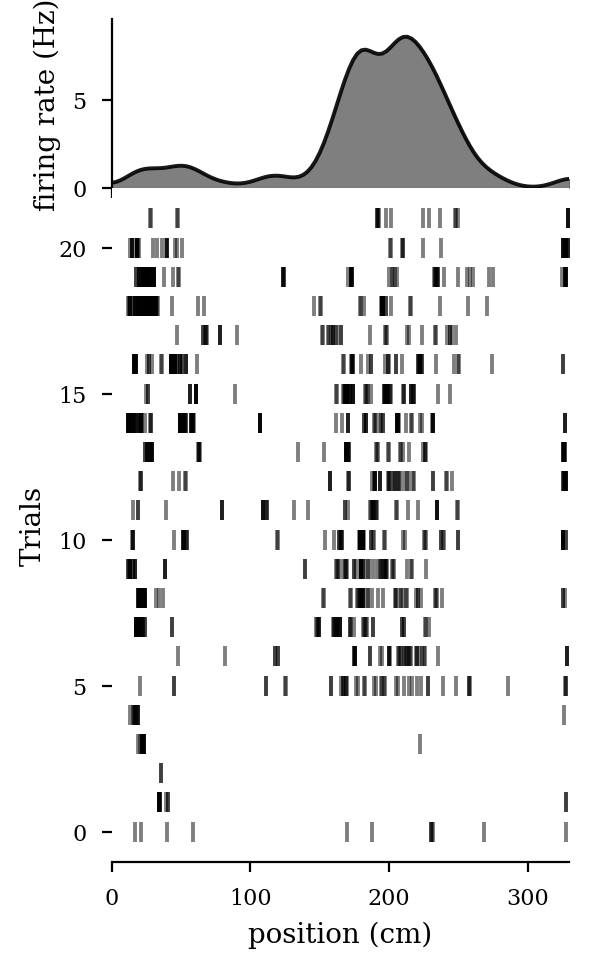

In [342]:
unit_index = 7

# fig,ax = plt.subplots(2,1,figsize=(3,3))
fig, axs = plt.subplots(
    2,
    1,
    figsize=functions.set_size("thesis", fraction=0.5, subplots=(3, 1)),
    gridspec_kw={"height_ratios": [1, 4]},
    sharex=True,
)
axs = axs.ravel()
plt.subplots_adjust(hspace=0)

spatial_offset = np.abs(spatial_maps.bin_centers.min())
x = spatial_maps.bin_centers + spatial_offset
axs[0].plot(x,spatial_maps.smooth(sigma=10).ratemap[unit_index],alpha=.9,color="k")
axs[0].fill_between(x,spatial_maps.smooth(sigma=10).ratemap[unit_index],alpha=.5,color="k")
axs[0].set_ylabel('firing rate (Hz)')
axs[0].set_xlim([0,x.max()])
axs[0].set_ylim([0,spatial_maps.smooth(sigma=10).ratemap[unit_index].max()+1])

for ep_i, ep in enumerate(outbound_epochs):
    axs[1].scatter(spk_pos[ep_i]+spatial_offset,np.ones_like(spk_pos[ep_i])*ep_i,alpha=.5,s=50,marker="|",color="k")
# axs[0].set_xticks([])
axs[1].set_xlabel('position (cm)')
axs[1].set_ylabel('Trials')

sns.despine(ax=axs[0],bottom=True)
sns.despine(ax=axs[1], left=True, bottom=False)

plt.savefig(
    os.path.join(fig_save_path, "place_cell_example_lineartrack_grant.svg"),
    dpi=300,
    bbox_inches="tight",
)
plt.savefig(
    os.path.join(fig_save_path, "place_cell_example_lineartrack_grant.pdf"),
    dpi=300,
    bbox_inches="tight",
)
plt.show()


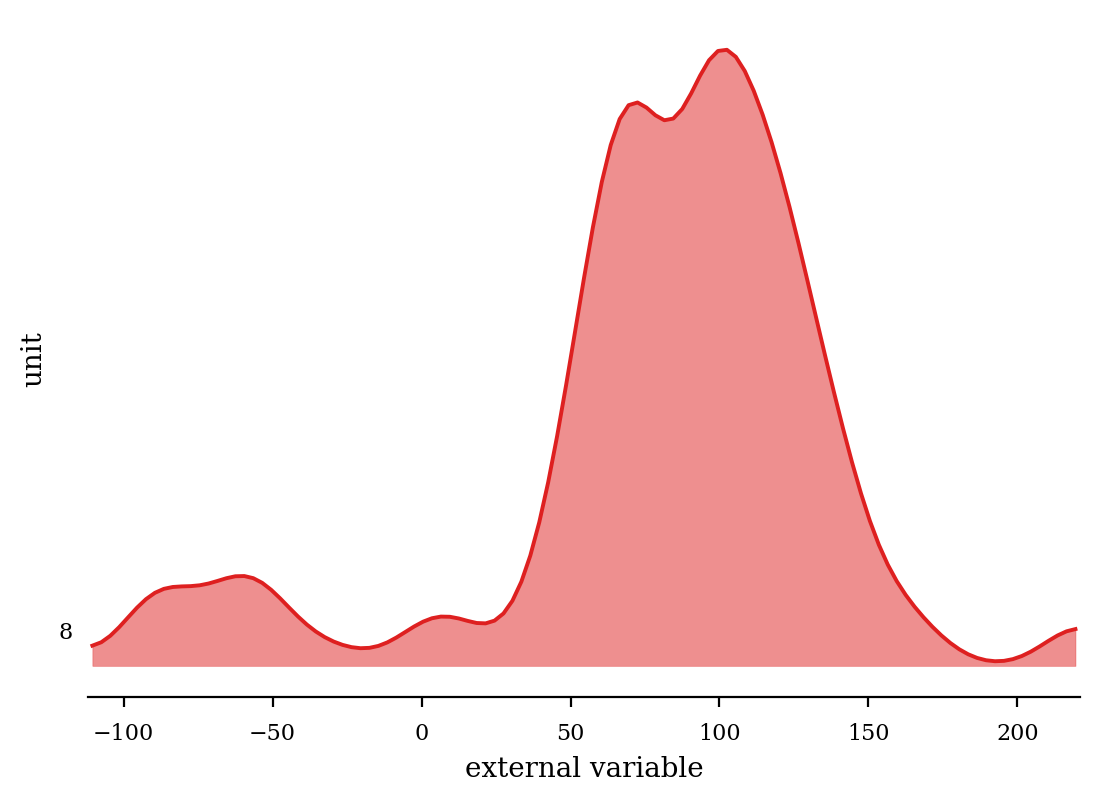

In [282]:
# plt.plot(spatial_maps.ratemap[7])

ax1 = npl.plot_tuning_curves1D(
    spatial_maps.tc._unit_subset([8]).smooth(sigma=10), normalize=False, pad=1, fill=True, alpha=0.5
)